In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./data/eurusd_1d_2024-1-24_2024-5-31.csv')
df.set_index("date", inplace=True)
df

,open,high,low,close,volume
date,,,,,
2024-01-25,1.08840,1.09021,1.08213,1.08455,236632
2024-01-26,1.08455,1.08857,1.08128,1.08533,184258
2024-01-29,1.08440,1.08502,1.07957,1.08321,168740
2024-01-30,1.08314,1.08575,1.08116,1.08451,193552
2024-01-31,1.08451,1.08876,1.07945,1.08174,321617
...,...,...,...,...,...
2024-05-27,1.08480,1.08674,1.08409,1.08581,18390
2024-05-28,1.08564,1.08890,1.08506,1.08559,33911
2024-05-29,1.08555,1.08588,1.07994,1.08003,33542


In [4]:
# Trend Quality Indicator
def trend_quality(series: pd.Series, fast_period: int = 7, slow_period: int = 15, 
trend_period: int = 4, noise_period: int = 250, c: float = 2.0, noise_type: str = "squared") -> pd.DataFrame:
                   
  # calculate moving averages
  ma_fast = series.ewm(span=fast_period).mean()
  ma_slow = series.ewm(span=slow_period).mean()

  # calculate crossovers
  fast_shift = ma_fast.shift(1)
  slow_shift = ma_slow.shift(1)
  up_cross = (ma_fast > ma_slow) & (fast_shift < slow_shift)
  down_cross = (ma_fast < ma_slow) & (fast_shift > slow_shift)
  crosses = series[up_cross | down_cross].index.to_list()
  crosses.append(None)  # add None to include last cycle

  # calculate price change
  pc = series.diff().fillna(0)

  # calculate cumulative price change
  cpc = pd.Series(0., index=series.index)
  last_idx = None
  for idx in crosses:
      cpc.loc[last_idx:idx] = pc.loc[last_idx:idx].cumsum()
      last_idx = idx

  # calculate trend
  trend = cpc.ewm(span=trend_period).mean()

  # calculate noise
  if noise_type == "linear":
      abs_diff = (cpc - trend).abs()
      noise = abs_diff.ewm(span=noise_period).mean()
  elif noise_type == "squared":
      square_diff = (cpc - trend) ** 2
      noise = np.sqrt(square_diff.ewm(span=noise_period).mean())
  else:
      raise ValueError("Noise type invalid.")

  # calculate q indicator
  q_indicator = trend / (noise * c)

  # calculate b indicator
  b_indicator = trend.abs() / (trend.abs() + noise) * 100

  # return indicators
  return pd.DataFrame({
      "Price Change": pc,
      "Cumulative Price Change": cpc,
      "Trend": trend,
      "Noise": noise,
      "Q_Indicator": q_indicator,
      "B_Indicator": b_indicator
  }, index=series.index)

In [5]:
tq = trend_quality(df['close'])
tq

,Price Change,Cumulative Price Change,Trend,Noise,Q_Indicator,B_Indicator
date,,,,,,
2024-01-25,0.00000,0.00000,0.000000,0.000000,NaN,NaN
2024-01-26,0.00078,0.00078,0.000488,0.000207,1.176161,70.169936
2024-01-29,-0.00212,-0.00212,-0.000843,0.000759,-0.555006,52.606889
2024-01-30,0.00130,-0.00082,-0.000832,0.000656,-0.634123,55.913071
2024-01-31,-0.00277,-0.00359,-0.002028,0.000916,-1.107420,68.894260
...,...,...,...,...,...,...
2024-05-27,0.00124,0.01336,0.012067,0.003159,1.910077,79.253779
2024-05-28,-0.00022,0.01314,0.012496,0.003135,1.992987,79.943739
2024-05-29,-0.00556,0.00758,0.010530,0.003132,1.680846,77.073120


In [6]:
df = pd.concat([df, tq], axis=1)

In [7]:
df

,open,high,low,close,volume,Price Change,Cumulative Price Change,Trend,Noise,Q_Indicator,B_Indicator
date,,,,,,,,,,,
2024-01-25,1.08840,1.09021,1.08213,1.08455,236632,0.00000,0.00000,0.000000,0.000000,NaN,NaN
2024-01-26,1.08455,1.08857,1.08128,1.08533,184258,0.00078,0.00078,0.000488,0.000207,1.176161,70.169936
2024-01-29,1.08440,1.08502,1.07957,1.08321,168740,-0.00212,-0.00212,-0.000843,0.000759,-0.555006,52.606889
2024-01-30,1.08314,1.08575,1.08116,1.08451,193552,0.00130,-0.00082,-0.000832,0.000656,-0.634123,55.913071
2024-01-31,1.08451,1.08876,1.07945,1.08174,321617,-0.00277,-0.00359,-0.002028,0.000916,-1.107420,68.894260
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,1.08480,1.08674,1.08409,1.08581,18390,0.00124,0.01336,0.012067,0.003159,1.910077,79.253779
2024-05-28,1.08564,1.08890,1.08506,1.08559,33911,-0.00022,0.01314,0.012496,0.003135,1.992987,79.943739
2024-05-29,1.08555,1.08588,1.07994,1.08003,33542,-0.00556,0.00758,0.010530,0.003132,1.680846,77.073120


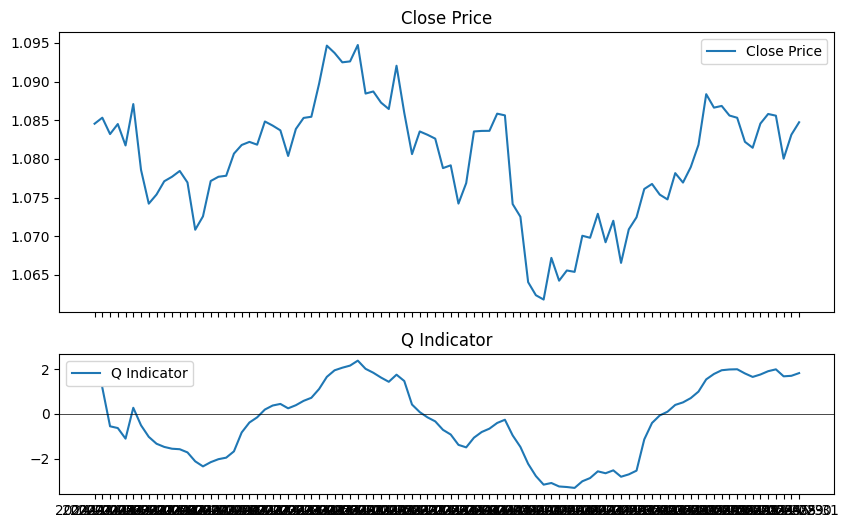

In [8]:
#visual check

fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]}, figsize=(10, 6))

ax[0].plot(df.index, df['close'], label='Close Price')
ax[0].set_title('Close Price')
ax[0].legend()

ax[1].plot(df.index, df['Q_Indicator'], label='Q Indicator')
ax[1].set_title('Q Indicator')
ax[1].axhline(0, color='black', linewidth=0.5)  
ax[1].legend()

plt.show()

In [11]:
# numbers check
# according to my mql4 terminal with mladen's version loaded, the value of the Q indicator on 5/02/2024 should be -2.2035 
# and on 5/3/2024 it should reset to 0

df.loc['2024-05-02', 'Q_Indicator'] 

-2.5396515320754287

In [12]:
df.loc['2024-05-03', 'Q_Indicator'] 

-1.14043725357845

In [ ]:
# to verify this, you could install mql4, then load EURUSD with the indicator provided in the reference folder.
# or more simply, check the visual reference I have included